# Project 15 - CIFAR-10 Image Classification

In [37]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
from collections import Counter

In [3]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_data[0]

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

In [5]:
type(train_data)

torchvision.datasets.cifar.CIFAR10

In [30]:
train_data.data.shape

(50000, 32, 32, 3)

In [36]:
np.unique(np.array(train_data.targets)) 

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [38]:
print(Counter(train_data.targets))

Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


Text(0.5, 1.0, 'Class frog')

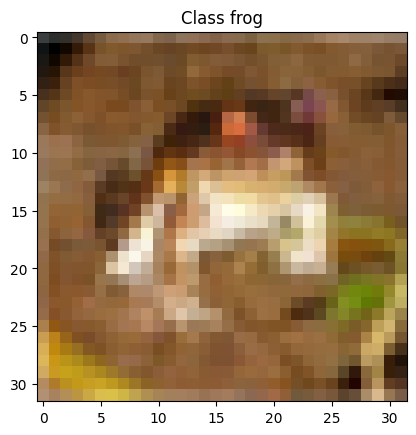

In [29]:
plt.imshow(train_data.data[0])

plt.title('Class ' + str(train_data.classes[train_data.targets[0]]))

In [42]:
train_data.data[0].shape

(32, 32, 3)

In [31]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128)

In [43]:
class classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3))
        self.conv2 = nn.Conv2d(32, 32, (3,3))
        self.activation = nn.ReLU()

        self.bnorm = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()

        # output = (input - filter + 1)/stride
        # conv1 = (32-03 + 1) /1 -> 30
        # pool1 = (30 -2 + 1) /2 -> 15
        # conv2 = (15 - 3 + 1) /1 -> 13
        # pool2 = (13 - 2 + 1) /2 -> 6
        # image is now 6x6 pixels
        # 32 filters of 6x6 pixels

        self.linear1 = nn.Linear(32*6*6, 128)
        self.linear2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, X):
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.pool(self.bnorm(self.activation(self.conv2(X))))
        X = self.flatten(X)

        X = self.dropout(self.activation(self.linear1(X)))
        X = self.dropout(self.activation(self.linear2(X)))
        X = self.output(X)

        return X

In [44]:
net = classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [68]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1152, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [62]:
def train_loop(loader, epoch):
    running_loss = 0
    runing_accuracy = 0.

    for i, data in enumerate(loader):
        inputs, labels = data

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        ps = F.softmax(outputs, dim=1)

        top_p, top_class = ps.topk(k=1, dim=1)
        equals = top_class == labels.view(*top_class.shape)

        accuracy = torch.mean(equals.type(torch.float))

        runing_accuracy += accuracy

        print(f'Epoch {epoch} - Batch {i} - Loss {running_loss/(i+1)} - Accuracy {runing_accuracy/(i+1)}')
    
    print(f'Epoch {epoch} - Loss {running_loss/len(loader)} - Accuracy {runing_accuracy/len(loader)}')

In [63]:
for epoch in range(3):
    print('Training...')
    train_loop(train_loader, epoch)
    
    net.eval()
    print('Testing...')
    train_loop(test_loader, epoch)
    net.train()


Training...
Epoch 0 - Batch 0 - Loss 0.868009626865387 - Accuracy 0.71875
Epoch 0 - Batch 1 - Loss 0.9224379658699036 - Accuracy 0.6953125
Epoch 0 - Batch 2 - Loss 0.933422843615214 - Accuracy 0.6901041865348816
Epoch 0 - Batch 3 - Loss 0.9481247514486313 - Accuracy 0.673828125
Epoch 0 - Batch 4 - Loss 0.9636596083641052 - Accuracy 0.6781250238418579
Epoch 0 - Batch 5 - Loss 0.9863843619823456 - Accuracy 0.6614583730697632
Epoch 0 - Batch 6 - Loss 1.015109121799469 - Accuracy 0.6573660969734192
Epoch 0 - Batch 7 - Loss 0.9930089637637138 - Accuracy 0.6572265625
Epoch 0 - Batch 8 - Loss 0.980266789595286 - Accuracy 0.663194477558136
Epoch 0 - Batch 9 - Loss 0.9612057507038116 - Accuracy 0.672656238079071
Epoch 0 - Batch 10 - Loss 0.9635274735364047 - Accuracy 0.6690341234207153
Epoch 0 - Batch 11 - Loss 0.9724379181861877 - Accuracy 0.6673177480697632
Epoch 0 - Batch 12 - Loss 0.9731525916319627 - Accuracy 0.6664663553237915
Epoch 0 - Batch 13 - Loss 0.9699321900095258 - Accuracy 0.6662

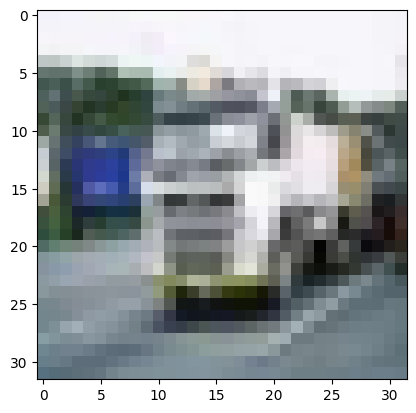

In [173]:
image = train_data.data[1000]
plt.imshow(image, cmap='gray')

In [163]:
image = image.reshape(1, 3, 32, 32)
image = torch.tensor(image).float()

In [164]:
net.eval()

classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1152, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [165]:
forecast = net.forward(image.to(device))
forecast

tensor([[ 233.9159,  181.9742, -363.3521, -195.6751, -447.3539, -356.2917,
         -371.2379, -399.2553,   33.1954,  245.1355]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [166]:
forecast = F.softmax(forecast, dim=1)
forecast

tensor([[1.3408e-05, 3.7101e-28, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 9.9999e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [167]:
forecast = forecast.cpu().detach().numpy()

In [168]:
result = np.argmax(forecast)

In [169]:
result

9

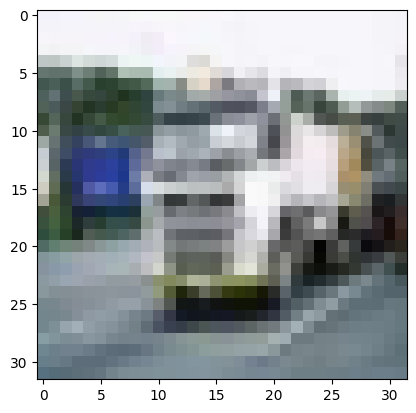

In [171]:
plt.imshow(train_data.data[1000])

In [170]:
print('The image is a', train_data.classes[result])

The image is a truck
